In [21]:
import jax
import jax.numpy as jnp
import numpy as np
import flax
from flax import linen as nn
from flax import nnx
import optax
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
from collections import defaultdict

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'


In [22]:
@jax.jit
def ternary_activation(x, thresholds):
    """
    Ternary activation function
    """
    # threshold
    t1, t2 = thresholds
    s = jnp.where(
        x < t1, -1.0,
        jnp.where(
            x > t2, 1.0,
            0.0
        )
    )

    return s

@jax.jit
def ternary_stochastic(x, thresholds, noise_sd, key):
    key, key1 = jax.random.split(key, num = 2)
    noise = jax.random.normal(key1, shape = x.shape) * noise_sd

    x = x + noise

    t1, t2 = thresholds
    s = jnp.where(
        x < t1, -1.0,
        jnp.where(
            x > t2, 1.0,
            0.0
        )
    )

    return s


## helper function
@jax.jit
def gaussian_cdf(x, mu, sigma):
    return jax.scipy.stats.norm.cdf(x, loc = mu, scale = sigma)

@jax.jit
def gaussian_pdf(x, mu, sigma):
    return jax.scipy.stats.norm.pdf(x, loc = mu, scale = sigma)


In [23]:
@jax.custom_vjp
def ternary_with_grad(x, thresholds, noise_sd, key):
    return ternary_stochastic(x, thresholds, noise_sd, key)

def ternary_with_grad_fwd(x, thresholds, noise_sd, key):
    return ternary_with_grad(x, thresholds, noise_sd, key), (x, thresholds, noise_sd)

def ternary_with_grad_bwd(res, grads):
    x, thresholds, noise_sd = res
    t1, t2 = thresholds
    exp_state_grad = gaussian_pdf(x = t1 - x, mu = 0, sigma = noise_sd) + gaussian_pdf(x = t2 - x, mu = 0, sigma = noise_sd)
    return (exp_state_grad * grads, None, None, None)

ternary_with_grad.defvjp(ternary_with_grad_fwd, ternary_with_grad_bwd)


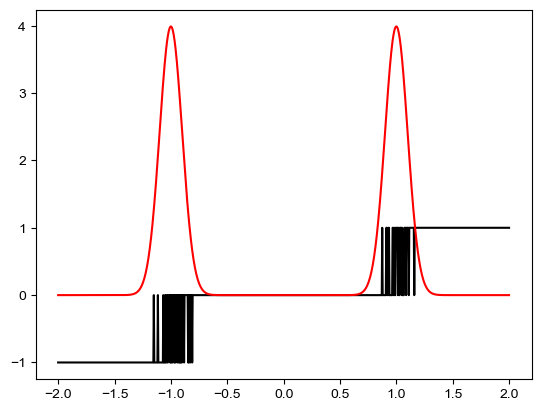

In [26]:
# check
t = np.linspace(-2, 2, 1000)
th = [-1., 1.]
nsd = 0.1
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, num = 1000)

act = jax.vmap(lambda x, k: ternary_with_grad(x, th, nsd, k))(t, keys)
# Compute gradients for each element using vmap with grad
grad_acts = jax.vmap(lambda x, k: jax.grad(lambda x_: ternary_with_grad(x_, th, nsd, k))(x))(t, keys)

plt.plot(t, act, '-k')
plt.plot(t, grad_acts, '-r')

Produce a drift in the weight matrix. For simplicity the noise comes from a uniform distribution

In [27]:
## initialize the vectors and ground truth weights
X = jax.random.randint(key = jax.random.key(0), shape = (100, 10), minval = -1, maxval = 2)
W_gt = jax.random.normal(shape = (100, 100), key = jax.random.key(0))
y_target = jnp.matmul(W_gt, X)
# print(y_target)

y_target_ter = jax.vmap(ternary_activation, in_axes = (0, None))(y_target, jnp.array([-1, 1]))
print(y_target_ter[:, 0])

[-1. -1.  1.  0. -1.  0. -1.  0.  1.  1.  1.  1. -1.  0.  1. -1. -1.  0.
  0.  1.  1.  1.  1. -1.  1.  1.  0.  1. -1. -1. -1.  0. -1. -1.  1. -1.
  1. -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  0.
 -1.  1. -1.  1. -1.  1.  0.  1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1.
 -1. -1.  1.  1. -1.  1.  0.  1. -1. -1.  1.  1. -1.  1.  1.  1. -1. -1.
  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.]


In [29]:
## define the error matrix
error_mat = jax.random.uniform(key = jax.random.key(0), shape = (100, 100), minval = -0.05, maxval = 0.05)
W_err = W_gt * error_mat + W_gt

# print out the norm of error - ground truth matrix
print(f"Norm drift = {jnp.linalg.norm(W_err - W_gt)}")
# print(f"Norm of ground truth = {jnp.linalg.norm(W_gt - W_gt)}")

# test what y's this gives
y_err = jnp.matmul(W_err, X)
y_err = jax.vmap(ternary_activation, in_axes = (0, None))(y_err, jnp.array([-1, 1]))

print(f"Norm of target vector drift = {jnp.linalg.norm(y_err - y_target_ter)}")


Norm drift = 4.248536586761475
Norm of target vector drift = 5.916079998016357


In [42]:
print(X.shape, W_err.shape)
jnp.matmul(W_err, X)

(100, 10) (100, 100)


Array([[-2.51535511e+00,  8.99687958e+00, -4.62740898e+00,
        -7.64439523e-01,  1.61651077e+01,  1.78945236e+01,
         2.71356344e+00, -4.48022127e+00,  1.07578478e+01,
        -3.49790454e-02],
       [-9.79690552e+00, -7.94578648e+00,  2.01323814e+01,
        -1.06101694e+01,  1.84582710e+00, -7.44885826e+00,
        -1.35543518e+01, -3.33329058e+00,  9.85988855e-01,
        -5.59254074e+00],
       [ 1.72471771e+01, -1.08498335e+00, -8.44849396e+00,
        -2.68664598e-01, -1.25323362e+01,  1.85299325e+00,
         8.88212013e+00,  4.04702091e+00,  2.29887438e+00,
        -7.04797220e+00],
       [ 6.99825346e-01, -8.93173981e+00,  1.85088515e+00,
        -2.69946074e+00,  2.80266643e+00, -4.91904354e+00,
        -7.52446365e+00,  6.17221498e+00,  1.95167780e+00,
         5.15005887e-01],
       [-6.34631538e+00, -5.86424828e+00, -4.41578436e+00,
         8.67772198e+00,  4.40217257e+00,  3.66278887e+00,
        -1.43164742e+00, -8.65012550e+00, -1.73041093e+00,
        -3.

In [272]:
## define the loss function
def mse_loss(W, X, y_target_ternary, thresholds, noise_sd, key):
    y_pred = jnp.matmul(W, X)
    y_pred_ter = jax.vmap(ternary_with_grad, in_axes=(0, None, None, None))(y_pred, thresholds, noise_sd, key)
    return jnp.mean(jnp.square(y_pred_ter - y_target_ternary))

In [309]:
## loop and update
lr = 1e0
thr = [-1., 1.]
nsd = 1e-1
key = jax.random.PRNGKey(0)
num_steps = 5001
keys = jax.random.split(key, num = num_steps)
losses = []
w_norms = []
w_traj = defaultdict(jnp.array)


In [310]:
N_samples = int(16)
N_features = int(1000)
X = jax.random.randint(key = jax.random.key(0), shape = (N_samples, N_features), minval = -1, maxval = 2)
W_gt = jax.random.normal(shape = (N_samples, N_samples), key = jax.random.key(0))
y_target = jnp.matmul(W_gt, X)
# print(y_target)

y_target_ter = jax.vmap(ternary_activation, in_axes = (0, None))(y_target, jnp.array([-1, 1]))

## define the error matrix
error_mat = jax.random.uniform(key = jax.random.key(0), shape = (N_samples, N_samples), minval = -0.8, maxval = 0.8)
W_err = jax.random.normal(shape = (N_samples, N_samples), key = jax.random.key(1))#W_gt * error_mat + W_gt


In [311]:
for step in range(num_steps):

    ## capture the weights every 500 steps
    if step%500 == 0:
        print(f"Step {step}, Loss = {loss}")
        w_traj[step] = W_gt - W_err
    
    key, subkey = jax.random.split(key)
    loss, loss_grad = jax.value_and_grad(mse_loss)(W_err, X, y_target_ter, thr, nsd, key)

    W_err = W_err - lr * loss_grad

    # append losses and error norms
    w_norms.append(jnp.linalg.norm(W_err - W_gt)/jnp.linalg.norm(W_gt))

    losses.append(loss)


Step 0, Loss = 0.6287499666213989
Step 500, Loss = 0.06237500160932541
Step 1000, Loss = 0.018187500536441803
Step 1500, Loss = 0.016437500715255737
Step 2000, Loss = 0.01875000074505806
Step 2500, Loss = 0.015937501564621925
Step 3000, Loss = 0.016625000163912773
Step 3500, Loss = 0.017250001430511475
Step 4000, Loss = 0.017750000581145287
Step 4500, Loss = 0.017625000327825546
Step 5000, Loss = 0.017125001177191734


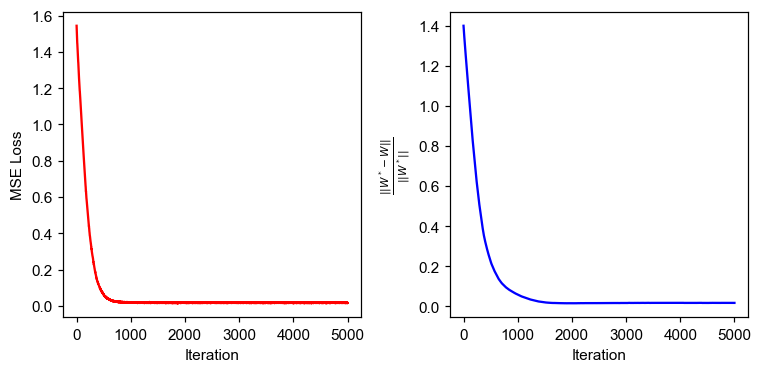

In [312]:
fig, ax = plt.subplots(1, 2, dpi = 110, figsize = (7, 3.5))
ax[0].plot(losses, '-r')
ax[1].plot(w_norms, '-b')

ax[0].set_xlabel('Iteration')

ax[1].set_xlabel('Iteration')
ax[0].set_ylabel('MSE Loss')
ax[1].set_ylabel(r"$\frac{||W^* - W||}{||W^*||}$")


plt.tight_layout()

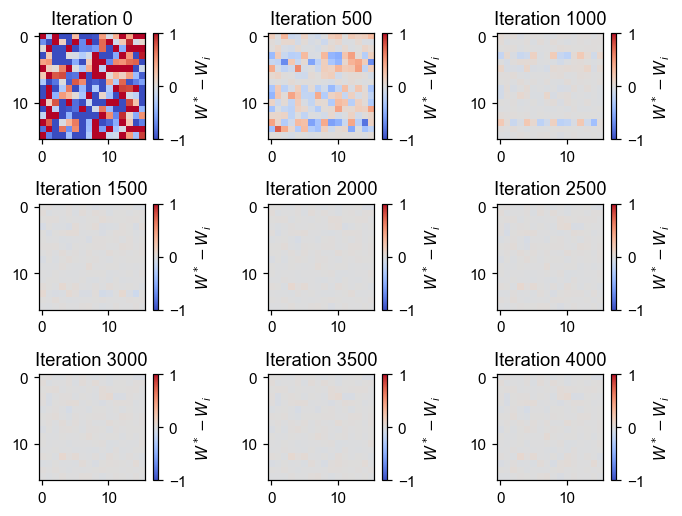

In [313]:
fig, ax = plt.subplots(3, 3, dpi = 110)

for axs, s in zip(ax.ravel(), w_traj.keys()):
    im = axs.imshow(w_traj[s], cmap = 'coolwarm', vmax = 1, vmin = -1)
    cbar = plt.colorbar(im, ax = axs)
    cbar.set_label(r'$W^* - W_i$')
    axs.set_title(f"Iteration {s}")

plt.tight_layout()

<Axes: >

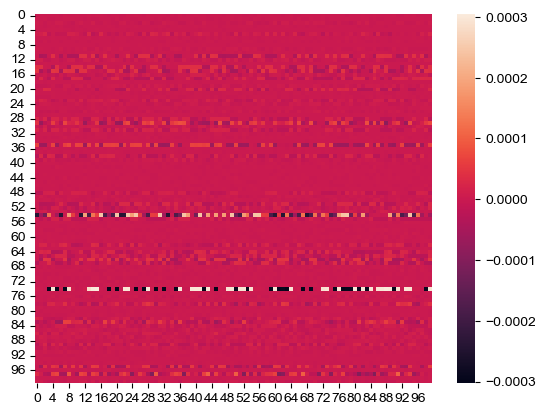

In [288]:
sns.heatmap(loss_grad)

In [287]:
loss_grad.shape

(100, 100)